# Cross-Domain Recommendation System Development
This notebook is an experiment in building a cross-domain recommendation system using the Amazon Reviews dataset. It uses the best model from the single-domain experiments and extends it to handle multiple domains. The dataset is the same as in the single-domain experiments, but now will combine data from two different domains.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from collections import defaultdict

# os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
# os.environ["HF_DATASETS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"
# os.environ["TRANSFORMERS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/models"

os.environ["HF_HOME"] = "E:/Python Scripts/recsys"
os.environ['HF_DATASETS_CACHE'] = "E:/Python Scripts/recsys/data"
os.environ['TRANSFORMERS_CACHE'] = "E:/Python Scripts/recsys/models"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Features, Value
from tqdm import tqdm
from tensorboardX import SummaryWriter

E:\Python Scripts\recsys\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Single-domain development on best model (SASRec)

In [3]:
HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"

def load_amazon_reviews(domain, save_dir="data", max_items=None, seed=SEED):
    os.makedirs(save_dir, exist_ok=True)
    filepath = f"{save_dir}/amazon_reviews_{domain}.csv"

    if not os.path.exists(filepath):
        print(f"File {filepath} not found. Downloading dataset for domain '{domain}'...")
        ds = load_dataset(
            "McAuley-Lab/Amazon-Reviews-2023",
            f"raw_review_{domain}",
            split="full",
            trust_remote_code=True,
        )

        # Keep only needed columns
        ds = ds.select_columns(["user_id", "parent_asin", "rating", "timestamp"])
        ds = ds.rename_columns({"user_id": "user", "parent_asin": "item"})
        ds = ds.cast(Features({
            "user": Value("string"),
            "item": Value("string"),
            "rating": Value("float32"),
            "timestamp": Value("int64"),
        }))

        # Convert to pandas (Arrow zero-copy where possible)
        df = ds.to_pandas()
        df.insert(3, "domain", domain)
        df.to_csv(f"{save_dir}/amazon_reviews_{domain}.csv", index=False)
        print(f"Saved amazon_reviews_{domain}.csv to {save_dir}/")

    final_df = pd.read_csv(filepath)
    # Random subset if max_items is set
    if max_items is not None:
        k = min(max_items, len(final_df))
        final_df = final_df.sample(n=k, random_state=seed).reset_index(drop=True)
    print(f"Loaded {filepath} with {len(final_df)} rows.")
    return final_df

def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    # Make it implicit
    df["label"] = 1.0
    user_counts = df.groupby("user").size()
    valid_users = user_counts[user_counts >= min_user_interactions].index
    item_counts = df.groupby("item").size()
    valid_items = item_counts[item_counts >= min_item_interactions].index
    df_filtered = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)]
    print("After interactions filtering:", len(df_filtered), "rows,", df_filtered["user"].nunique(), "users,", df_filtered["item"].nunique(), "items")
    return df_filtered

def label_encoder(df, shift_item_id=False):
    df_encoded = df.copy()
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    domain_enc = LabelEncoder()
    df_encoded["user_id"] = user_enc.fit_transform(df_encoded["user"])
    df_encoded["item_id"] = item_enc.fit_transform(df_encoded["item"])
    if shift_item_id:
        df_encoded["item_id"] = df_encoded["item_id"] + 1  # Shift item IDs by 1 to reserve 0 for padding if needed
    df_encoded["domain_id"] = domain_enc.fit_transform(df_encoded["domain"])
    return df_encoded, user_enc, item_enc, domain_enc

### Dataset preparation

In [4]:
# New input
SOURCE_DOMAIN = "Books"

# Loading data from multiple domains
df = load_amazon_reviews(SOURCE_DOMAIN, max_items=2_000_000, seed=SEED)
print(f"Total rows in {SOURCE_DOMAIN}: {len(df)}")

# Preprocess the dataset
filtered_df = preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5)
df_encoded, user_encoder, item_encoder, domain_encoder = label_encoder(filtered_df, shift_item_id=True)

NUM_USERS = df_encoded["user_id"].max() + 1
NUM_ITEMS = df_encoded["item_id"].max() + 1
print(f"Number of users: {NUM_USERS}, Number of items: {NUM_ITEMS}")

Loaded data/amazon_reviews_Books.csv with 4000000 rows.
Total rows in Books: 4000000
After interactions filtering: 28280 rows, 5004 users, 10350 items
Number of users: 5004, Number of items: 10351


In [5]:
def create_user_sequences(df):
    df_sorted = df.sort_values(["user_id", "timestamp"])
    user_sequences = {}
    for uid, group in df_sorted.groupby("user_id"):
        items = group["item_id"].tolist()
        user_sequences[uid] = items

    print(f"Number of users: {len(user_sequences)}")
    print(f"Max sequence length: {max(len(seq) for seq in user_sequences.values())}")
    print(f"Min sequence length: {min(len(seq) for seq in user_sequences.values())}")

    return user_sequences

# Create sequences
user_sequences = create_user_sequences(df_encoded)
pos_items_by_user = {u: set(seq) for u, seq in user_sequences.items()}

Number of users: 5004
Max sequence length: 70
Min sequence length: 1


In [6]:
def sequences_loo_split(user_sequences):
    train_seqs = {}
    val_data = {}
    test_data = {}

    for user, seq in user_sequences.items():
        if len(seq) < 3:  # Need at least 3 items for train/val/test
            continue

        train_seqs[user] = seq[:-2]  # All but last two
        val_data[user] = (seq[:-2], seq[-2])  # Train on all but last 2, predict second-to-last
        test_data[user] = (seq[:-1], seq[-1])  # Train on all but last, predict last

    print(f"Training sequences: {len(train_seqs)}")
    print(f"Validation users: {len(val_data)}")
    print(f"Test users: {len(test_data)}")

    return train_seqs, val_data, test_data

train_sequences, val_sequences, test_sequences = sequences_loo_split(user_sequences)
print(f"Sequences - Train: {len(train_sequences)}, Val: {len(val_sequences)}, Test: {len(test_sequences)}")

Training sequences: 3264
Validation users: 3264
Test users: 3264
Sequences - Train: 3264, Val: 3264, Test: 3264


### Dataset and DataLoader

In [7]:
class SASRecDataset(Dataset):
    def __init__(self, data, num_items, max_seq_len=50, pos_items_by_user=None, mode="train", neg_samples=1):
        self.num_items = num_items
        self.max_seq_len = max_seq_len
        self.mode = mode
        self.neg_samples = neg_samples
        self.all_pos = pos_items_by_user

        self.samples = []
        if mode == "train":
            for user, seq in data.items():
                for i in range(1, len(seq)):
                    self.samples.append({
                        "user": user,
                        "input_seq": seq[:i],
                        "target": seq[i],
                        "full_seq": seq # For negative sampling
                    })
        else:
            for user, (seq, target) in data.items():
                self.samples.append({
                    "user": user,
                    "input_seq": seq,
                    "target": target,
                    "full_seq": seq + [target]
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        user = sample["user"]
        seq = sample["input_seq"]
        target = sample["target"]

        # Truncate sequence if > max length
        if len(seq) > self.max_seq_len:
            seq = seq[-self.max_seq_len:]

        # Left-pad sequence with zeros
        pad_len = self.max_seq_len - len(seq)
        padded_seq = [0] * pad_len + seq

        # Negative sampling
        forbid = self.all_pos[user] if self.all_pos is not None else set(sample["full_seq"])
        neg_items = set()

        while len(neg_items) < self.neg_samples:
            neg = random.randint(1, self.num_items - 1)
            if neg not in forbid:
                neg_items.add(neg)

        return {
            "user": sample["user"],
            "input_seq": torch.tensor(padded_seq, dtype=torch.long),
            "target": torch.tensor(target, dtype=torch.long),
            "neg_items": torch.tensor(list(neg_items), dtype=torch.long)
        }

# Create datasets
train_dataset = SASRecDataset(train_sequences, NUM_ITEMS, pos_items_by_user=pos_items_by_user, max_seq_len=50, mode="train", neg_samples=1)
val_dataset = SASRecDataset(val_sequences, NUM_ITEMS, pos_items_by_user=pos_items_by_user, max_seq_len=50, mode="val", neg_samples=99)
test_dataset = SASRecDataset(test_sequences, NUM_ITEMS, pos_items_by_user=pos_items_by_user, max_seq_len=50, mode="test", neg_samples=99)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 15943
Validation samples: 3264
Test samples: 3264


In [8]:
# Create data loaders
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
first = next(iter(train_loader))
print("Sample batch from loader:")
print("Input sequence shape:", first["input_seq"].shape)
print("Target shape:", first["target"].shape)
print("Negative items shape:", first["neg_items"].shape)

print("\nSample input sequence:")
random_index = []
for _ in range(5):
    random_index.append(random.randint(0, len(train_loader) - 1))

for i in random_index:
    print(first["input_seq"][i])

Sample batch from loader:
Input sequence shape: torch.Size([4096, 50])
Target shape: torch.Size([4096])
Negative items shape: torch.Size([4096, 1])

Sample input sequence:
tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  138,  192, 2540, 4239, 5030, 2547,
         746, 3104])
tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 1265, 5146, 3114,
        3274, 1592])
tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0

### Create SASRec model

In [10]:
# Building SASRec model
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_dim, dropout=0.2):
        super().__init__()
        self.w1 = nn.Linear(hidden_dim, hidden_dim)
        self.w2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(self.relu(self.w1(x))))

class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout=0.2):
        super().__init__()

        # Multi-head attention
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)

        # Layer norms
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

        # Feed-forward network
        self.ffn = PointWiseFeedForward(hidden_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # Self-attention with residual connection
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = self.ln1(x + self.dropout(attn_out))

        # Feed-forward network with residual connection
        ffn_out = self.ffn(x)
        x = self.ln2(x + self.dropout(ffn_out))

        return x

class SASRec(nn.Module):
    def __init__(self,
                 num_items,
                 hidden_dim=64,
                 max_seq_len=50,
                 num_blocks=2,
                 num_heads=2,
                 dropout=0.2):
        super().__init__()

        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.max_seq_len = max_seq_len

        # Embedding layers
        self.item_embed = nn.Embedding(num_items, hidden_dim, padding_idx=0)
        self.positional_embed = nn.Embedding(max_seq_len, hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Stack of SASRec blocks
        self.blocks = nn.ModuleList([
            AttentionBlock(hidden_dim, num_heads, dropout) for _ in range(num_blocks)
        ])

        # Final layer norm
        self.ln = nn.LayerNorm(hidden_dim)

        # Initialize weights
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_normal_(self.item_embed.weight[1:])  # Skip padding idx
        nn.init.xavier_normal_(self.positional_embed.weight)

    def forward(self, input_seq, candidate_items=None):
        batch_size, seq_len = input_seq.shape

        # Get item embeddings
        item_embeds = self.item_embed(input_seq)  # [B, L, D]

        # Add positional embeddings
        positions = torch.arange(seq_len, device=input_seq.device).unsqueeze(0)
        pos_embeds = self.positional_embed(positions)  # [1, L, D]
        x = self.dropout(item_embeds + pos_embeds)

        # Create causal attention mask
        attn_mask = self._create_causal_mask(seq_len, input_seq.device)
        pad_mask = input_seq.eq(0)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x, attn_mask=attn_mask)

        # Final layer norm
        x = self.ln(x)  # [B, L, D]
        x = x.masked_fill(pad_mask.unsqueeze(-1), 0.0)

        # If candidate_items provided, score them
        if candidate_items is not None:
            # Get embeddings for candidate items
            cand_emb = self.item_embed(candidate_items) # [B, N, D]

            # Use last position's representation for scoring
            last_hidden = x[:, -1, :].unsqueeze(1)  # [B, 1, D]

            # Compute scores via dot product
            scores = torch.matmul(last_hidden, cand_emb.transpose(1, 2)).squeeze(1) # [B, N]
            return scores

        return x

    def _create_causal_mask(self, seq_len, device):
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device, dtype=torch.bool), diagonal=1)
        mask = mask.masked_fill(mask == 1, float("-inf"))
        return mask

    def predict_next(self, input_seq):
        # Get sequence representations
        seq_repr = self.forward(input_seq)  # [B, L, D]

        # Use last position for prediction
        last_hidden = seq_repr[:, -1, :]  # [B, D]

        # Score against all item embeddings
        all_item_embeds = self.item_embed.weight  # [num_items, D]
        scores = torch.matmul(last_hidden, all_item_embeds.T)  # [B, num_items]
        return scores

### Training and evaluation functions

In [11]:
def train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_seq = batch["input_seq"].to(device)
        pos_items = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        # Get predictions for last position
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]

        # Get embeddings for positive and negative items
        pos_embeds = model.item_embed(pos_items)
        neg_embeds = model.item_embed(neg_items)

        # Compute logits
        pos_logits = (last_hidden * pos_embeds).sum(dim=1)
        neg_logits = torch.bmm(neg_embeds, last_hidden.unsqueeze(-1)).squeeze(-1)

        # Binary cross-entropy loss with logits
        pos_labels = torch.ones_like(pos_logits)
        neg_labels = torch.zeros_like(neg_logits)

        # Concatenate logits and labels
        all_logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)

        loss = loss_fn(all_logits, all_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_batches += 1

    return total_loss / n_batches

In [12]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate_sasrec(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_mrr = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for batch in tqdm(eval_loader, desc="Evaluating"):
        input_seq = batch["input_seq"].to(device)
        target = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        batch_size = input_seq.size(0)

        # Create candidate set: 1 positive + negatives
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]
        candidates = torch.cat([
            target.unsqueeze(1),  # [B, 1]
            neg_items  # [B, neg_samples]
        ], dim=1)  # [B, 1 + neg_samples]

        # Get embeddings for all candidates
        cand_emb = model.item_embed(candidates)  # [B, 1+neg_samples, D]
        scores = torch.bmm(cand_emb, last_hidden.unsqueeze(-1)).squeeze(-1)  # [B, 1+neg_samples]

        # sanity: positive not in negatives
        if torch.any((candidates[:, 1:] == target.unsqueeze(1)).any(dim=1)):
            raise RuntimeError("Positive item appeared in negatives for some samples.")

        # Loss calculation
        pos_scores = scores[:, 0]
        neg_scores = scores[:, 1:]
        pos_labels = torch.ones_like(scores[:, 0])
        neg_labels = torch.zeros_like(scores[:, 1:])
        all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)
        batch_loss = loss_fn(all_scores.reshape(-1), all_labels.reshape(-1))
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

        # Calculate metrics
        _, full_idx = torch.sort(scores, dim=1, descending=True)
        rank  = (full_idx == 0).nonzero(as_tuple=True)[1] + 1  # Rank of the positive item (1-based)

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        mrr = torch.where(rank <= k, 1.0 / rank.float(), torch.zeros_like(hit))

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_mrr += mrr.sum().item()
        total += batch_size

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MRR@K": sum_mrr / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }

    return metrics

In [13]:
def sasrec_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        t0 = time.time()

        # Train (batched)
        train_loss = train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device=device)
        train_losses.append(train_loss)

        # Eval (batched)
        m = evaluate_sasrec(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MRR@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model_src.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model_src.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
        writer.add_scalar(f"Metrics/Val_MRR@{k}", m["MRR@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MRR@{k} {m['MRR@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    print("\nTraining Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

### Training the model

In [14]:
# Hyperparameters from the original paper, except higher hidden_dim
sasrec = SASRec(
    num_items=NUM_ITEMS,
    hidden_dim=64,
    max_seq_len=50,
    num_blocks=2,
    num_heads=2,
    dropout=0.2
)

loss_fn_sasrec = nn.BCEWithLogitsLoss()
optimizer_sasrec = torch.optim.Adam(sasrec.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses_sasrec, val_losses_sasrec, val_metrics_sasrec, best_ndcg_sasrec = sasrec_trainer(
    model=sasrec,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn_sasrec,
    optimizer=optimizer_sasrec,
    epochs=20,
    k=10,
    device=DEVICE,
    save_dir="model_sasrec"
)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 1/20  Train loss 0.6926  Val loss 0.6928  HR@10 0.1308  NDCG@10 0.0617  Precision@10 0.0131  MRR@10 0.0411  (new best)  Time 2.10s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 2/20  Train loss 0.6766  Val loss 0.6884  HR@10 0.1602  NDCG@10 0.0772  Precision@10 0.0160  MRR@10 0.0524  (new best)  Time 1.40s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 3/20  Train loss 0.6605  Val loss 0.6836  HR@10 0.1811  NDCG@10 0.0886  Precision@10 0.0181  MRR@10 0.0609  (new best)  Time 1.60s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 4/20  Train loss 0.6453  Val loss 0.6787  HR@10 0.1795  NDCG@10 0.0912  Precision@10 0.0180  MRR@10 0.0647  (new best)  Time 1.38s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Epoch 5/20  Train loss 0.6317  Val loss 0.6735  HR@10 0.1835  NDCG@10 0.0936  Precision@10 0.0184  MRR@10 0.0665  (new best)  Time 1.84s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch 6/20  Train loss 0.6190  Val loss 0.6693  HR@10 0.1896  NDCG@10 0.0964  Precision@10 0.0190  MRR@10 0.0684  (new best)  Time 1.53s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Epoch 7/20  Train loss 0.6080  Val loss 0.6656  HR@10 0.1939  NDCG@10 0.0981  Precision@10 0.0194  MRR@10 0.0694  (new best)  Time 1.56s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch 8/20  Train loss 0.5987  Val loss 0.6620  HR@10 0.1924  NDCG@10 0.0974  Precision@10 0.0192  MRR@10 0.0690    Time 1.68s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 9/20  Train loss 0.5922  Val loss 0.6589  HR@10 0.1945  NDCG@10 0.0975  Precision@10 0.0195  MRR@10 0.0684    Time 1.43s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 10/20  Train loss 0.5862  Val loss 0.6556  HR@10 0.1884  NDCG@10 0.0964  Precision@10 0.0188  MRR@10 0.0688    Time 1.60s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 11/20  Train loss 0.5790  Val loss 0.6523  HR@10 0.1924  NDCG@10 0.0979  Precision@10 0.0192  MRR@10 0.0696    Time 1.40s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch 12/20  Train loss 0.5755  Val loss 0.6497  HR@10 0.1903  NDCG@10 0.0969  Precision@10 0.0190  MRR@10 0.0689    Time 1.55s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch 13/20  Train loss 0.5729  Val loss 0.6453  HR@10 0.1915  NDCG@10 0.0963  Precision@10 0.0191  MRR@10 0.0678    Time 1.50s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch 14/20  Train loss 0.5692  Val loss 0.6424  HR@10 0.1942  NDCG@10 0.1014  Precision@10 0.0194  MRR@10 0.0735  (new best)  Time 1.54s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch 15/20  Train loss 0.5661  Val loss 0.6396  HR@10 0.1927  NDCG@10 0.0991  Precision@10 0.0193  MRR@10 0.0709    Time 1.67s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch 16/20  Train loss 0.5649  Val loss 0.6364  HR@10 0.1955  NDCG@10 0.0992  Precision@10 0.0195  MRR@10 0.0703    Time 1.42s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 17/20  Train loss 0.5602  Val loss 0.6327  HR@10 0.1952  NDCG@10 0.0988  Precision@10 0.0195  MRR@10 0.0698    Time 1.64s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch 18/20  Train loss 0.5580  Val loss 0.6300  HR@10 0.1973  NDCG@10 0.1000  Precision@10 0.0197  MRR@10 0.0708    Time 1.61s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch 19/20  Train loss 0.5590  Val loss 0.6284  HR@10 0.1933  NDCG@10 0.0978  Precision@10 0.0193  MRR@10 0.0691    Time 1.63s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch 20/20  Train loss 0.5574  Val loss 0.6241  HR@10 0.1979  NDCG@10 0.0990  Precision@10 0.0198  MRR@10 0.0694    Time 1.50s

Training Complete.
Best epoch: 14 with NDCG@10: 0.1014



## Cross-domain development

In [15]:
# Load trained model on source domain
def load_best_weights(model, ckpt_path="model/best_model.pth", device="cpu"):
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location="cpu")
    model.cpu()
    model.load_state_dict(state)
    model.to(device).eval()
    return model

### Align users across domains

In [37]:
@torch.no_grad()
def compute_user_reprs_from_sequences(model_src, train_seqs_src, user_encoder_src, max_seq_len=50, device=DEVICE):
    model_src.eval().to(device)
    user_vecs = {}

    for user_id, seq in train_seqs_src.items():
        if len(seq) < 1:
            continue

        # Pad-left to max_seq_len
        seq = seq[-max_seq_len:]
        pad_len = max_seq_len - len(seq)
        input_seq = torch.tensor([([0] * pad_len + seq)], dtype=torch.long, device=device)
        hidden = model_src(input_seq)
        last_hidden = hidden[0, -1, :].squeeze(0)
        raw_user = user_encoder_src.inverse_transform([user_id])[0]
        user_vecs[raw_user] = last_hidden.detach().cpu().numpy()

    print(f"\nComputed user representations for {len(user_vecs)} users.")
    return user_vecs

In [38]:
# Cross-domain evaluation on target domain
SOURCE_DOMAIN = "Books"
TARGET_DOMAIN = "Movies_and_TV"
ALL_DOMAIN = [SOURCE_DOMAIN, TARGET_DOMAIN]

# Load data from target domain
df_target = load_amazon_reviews(TARGET_DOMAIN, max_items=4_000_000, seed=SEED)
filtered_df_target = preprocess_dataset(df_target, min_user_interactions=20, min_item_interactions=20)
df_target_encoded, user_encoder_tgt, item_encoder_tgt, domain_encoder_tgt = label_encoder(filtered_df_target, shift_item_id=True)

NUM_USERS_TGT = df_target_encoded["user_id"].max() + 1
NUM_ITEMS_TGT = df_target_encoded["item_id"].max() + 1

# Rebuild sequences for target domain and split
user_sequences_tgt = create_user_sequences(df_target_encoded)
pos_items_by_user_tgt = {u: set(seq) for u, seq in user_sequences_tgt.items()}
train_sequences_tgt, val_sequences_tgt, test_sequences_tgt = sequences_loo_split(user_sequences_tgt)

# Build source user vectors from the trained source model
user_vecs_src = compute_user_reprs_from_sequences(
    model_src=sasrec,
    train_seqs_src=train_sequences,
    user_encoder_src=user_encoder,
    max_seq_len=50,
    device=DEVICE
)

# Create an aligned matrix of source vectors in target's user_id space
embed_dim = 64
transfer_src_mat = np.zeros((NUM_USERS_TGT, embed_dim), dtype=np.float32)
for raw_user, vec in user_vecs_src.items():
    if raw_user in user_encoder_tgt.classes_:
        uid_target = user_encoder_tgt.transform([raw_user])[0]
        transfer_src_mat[uid_target] = vec # give source user vector to target user_id (shared users)

transfer_src_mat = torch.tensor(transfer_src_mat)  # [U_T, D]
print("\n")
print(transfer_src_mat)

Loaded data/amazon_reviews_Movies_and_TV.csv with 4000000 rows.
After interactions filtering: 98935 rows, 5686 users, 26709 items
Number of users: 5686
Max sequence length: 270
Min sequence length: 1
Training sequences: 5534
Validation users: 5534
Test users: 5534

Computed user representations for 3264 users.


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.1074,  1.2010,  1.1540,  ..., -0.9452, -1.1309, -1.0154]])


### Dataset and DataLoader for cross-domain

In [39]:
# Additional dataset changes for cross-domain
class SASRecDatasetCD(SASRecDataset):
    def __init__(self, data, num_items, transfer_src_mat, max_seq_len=50, mode="train", neg_samples=1):
        super().__init__(data, num_items, max_seq_len=max_seq_len, mode=mode, neg_samples=neg_samples)
        self.transfer_src_mat = transfer_src_mat

    def __getitem__(self, idx):
        out = super().__getitem__(idx)
        user_id = out["user"]
        out["transfer_src"] = self.transfer_src_mat[user_id].float()
        return out

In [40]:
#Target datasets & loaders
train_dataset_tgt = SASRecDatasetCD(train_sequences_tgt, NUM_ITEMS_TGT, transfer_src_mat, max_seq_len=50, mode="train", neg_samples=1)
val_dataset_tgt = SASRecDatasetCD(val_sequences_tgt, NUM_ITEMS_TGT, transfer_src_mat, max_seq_len=50, mode="val", neg_samples=99)
test_dataset_tgt = SASRecDatasetCD(test_sequences_tgt, NUM_ITEMS_TGT, transfer_src_mat, max_seq_len=50, mode="test", neg_samples=99)

train_loader_tgt = DataLoader(train_dataset_tgt, batch_size=BATCH_SIZE, shuffle=True)
val_loader_tgt   = DataLoader(val_dataset_tgt,   batch_size=BATCH_SIZE, shuffle=False)
test_loader_tgt  = DataLoader(test_dataset_tgt,  batch_size=BATCH_SIZE, shuffle=False)

### Cross-domain SASRec model
This technique is inspired by the paper [Personalized Transfer of User Preferences for Cross-domain Recommendation (2021)](https://arxiv.org/abs/2110.11154).

In [41]:
# class SASRecCD(nn.Module):
#     def __init__(self, base_sasrec, hidden_dim=64, bridge_hidden=128, dropout=0.1):
#         super().__init__()
#         self.base = base_sasrec
#         self.bridge = nn.Sequential(
#             nn.Linear(hidden_dim, bridge_hidden),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(bridge_hidden, hidden_dim)
#         )
#         self.gate = nn.Linear(hidden_dim * 2, hidden_dim)
#
#     def forward(self, input_seq, transfer_src=None, candidate_items=None):
#         seq_output = self.base(input_seq)
#         last_hidden = seq_output[:, -1, :]
#
#         if transfer_src is not None:
#             bridge_out = self.bridge(transfer_src)
#             combined = torch.cat([last_hidden, bridge_out], dim=-1)
#             gate = torch.sigmoid(self.gate(combined))
#             fused = gate * last_hidden + (1.0 - gate) * bridge_out
#         else:
#             fused = last_hidden
#
#         if candidate_items is not None:
#             cand_emb = self.base.item_embed(candidate_items)
#             scores = torch.bmm(cand_emb, fused.unsqueeze(-1)).squeeze(-1)
#             return scores
#
#         return fused

In [96]:
class SASRecCD(nn.Module):
    def __init__(self, base_sasrec, hidden_dim=64, bridge_hidden=128, dropout=0.1):
        super().__init__()
        self.base = base_sasrec
        self.bridge = nn.Sequential(
            nn.Linear(hidden_dim, bridge_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(bridge_hidden, hidden_dim)
        )
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)


    def forward(self, input_seq, transfer_src=None, candidate_items=None):
        seq_output = self.base(input_seq)
        last_hidden = seq_output[:, -1, :]

        if transfer_src is not None:
            bridge_out = self.bridge(transfer_src)
            has_transfer = (transfer_src.abs().sum(dim=-1, keepdim=True) > 0).float()
            last_hidden_n = nn.functional.layer_norm(last_hidden, last_hidden.shape[-1:])
            bridge_out_n = nn.functional.layer_norm(bridge_out, bridge_out.shape[-1:])
            combined = torch.cat([last_hidden_n, bridge_out_n], dim=-1)
            gate = torch.sigmoid(self.linear(combined))
            fused_gate = gate * last_hidden + (1.0 - gate) * bridge_out
            fused = has_transfer * fused_gate + (1.0 - has_transfer) * last_hidden
        else:
            fused = last_hidden

        if candidate_items is not None:
            cand_emb = self.base.item_embed(candidate_items)
            scores = torch.bmm(cand_emb, fused.unsqueeze(-1)).squeeze(-1)
            return scores

        return fused

### Training and evaluation functions for cross-domain

In [97]:
def train_epoch_transfer(model, loader, loss_fn, optimizer, device="cpu"):
    model.train()
    total, n = 0.0, 0
    for batch in tqdm(loader, desc="Training"):
        inp = batch["input_seq"].to(device)
        pos = batch["target"].to(device)
        neg = batch["neg_items"].to(device)
        transfer = batch["transfer_src"].to(device)

        # fused representation
        fused = model(inp, transfer_src=transfer)
        pos_emb = model.base.item_embed(pos)
        neg_emb = model.base.item_embed(neg)

        pos_logits = (fused * pos_emb).sum(dim=1)
        neg_logits = torch.bmm(neg_emb, fused.unsqueeze(-1)).squeeze(-1)

        all_logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], 1)
        all_labels = torch.cat([torch.ones_like(pos_logits).unsqueeze(1),
                                torch.zeros_like(neg_logits)], 1)

        loss = loss_fn(all_logits.reshape(-1), all_labels.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item(); n += 1
    return total / n

In [98]:
@torch.no_grad()
def evaluate_transfer(model, loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = hits = ndcgs = precs = mrrs = 0.0
    loss_sum, nb = 0.0, 0

    for batch in tqdm(loader, desc="Evaluating"):
        inp = batch["input_seq"].to(device)
        tgt = batch["target"].to(device)
        neg = batch["neg_items"].to(device)
        transfer = batch["transfer_src"].to(device)

        fused = model(inp, transfer_src=transfer)
        cand = torch.cat([tgt.unsqueeze(1), neg], dim=1)
        cand_emb = model.base.item_embed(cand)
        scores = torch.bmm(cand_emb, fused.unsqueeze(-1)).squeeze(-1)

        # loss
        labels = torch.cat([torch.ones_like(scores[:, :1]),
                            torch.zeros_like(scores[:, 1:])], dim=1)
        batch_loss = loss_fn(scores.reshape(-1), labels.reshape(-1))
        loss_sum += batch_loss.item(); nb += 1

        # ranks & metrics
        _, idx = torch.sort(scores, dim=1, descending=True)
        rank = (idx == 0).nonzero(as_tuple=True)[1] + 1  # 1-based
        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        mrr = 1.0 / rank.float()

        B = inp.size(0)
        hits += hit.sum().item()
        ndcgs += ndcg.sum().item()
        precs += precision.sum().item()
        mrrs += mrr.sum().item()
        total += B

    return {
        "HR@K": hits / total,
        "NDCG@K": ndcgs / total,
        "Precision@K": precs / total,
        "MRR": mrrs / total,
        "Val loss": loss_sum / max(nb, 1)
    }

In [99]:
# Trainer (target domain)
def train_target_with_transfer(model, train_loader, val_loader, epochs, lr=1e-3, wd=1e-6, k=10, device="cpu"):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.BCEWithLogitsLoss()
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        train = train_epoch_transfer(model, train_loader, loss_fn, opt, device=device)
        eval = evaluate_transfer(model, val_loader, loss_fn, k=k, device=device)

        if eval["NDCG@K"] > best_ndcg:
            best_ndcg, best_epoch = eval["NDCG@K"], epoch+1
            torch.save(model.state_dict(), "model_sasrec/transfer_best.pth")

        print(f"Epoch {epoch+1}/{epochs}  "
              f"Train {train:.4f}  "
              f"Val {eval['Val loss']:.4f}  "
              f"HR@{k} {eval['HR@K']:.4f}  "
              f"NDCG@{k} {eval['NDCG@K']:.4f}  "
              f"Prec@{k} {eval['Precision@K']:.4f}  "
              f"MRR {eval['MRR']:.4f}  "
              f"{'(new best)' if eval['NDCG@K']==best_ndcg and best_epoch==epoch+1 else ''}")

    print(f"\nBest epoch {best_epoch} NDCG@{k}={best_ndcg:.4f}")
    return best_ndcg

### Training the cross-domain model

In [100]:
sasrec_base_model = load_best_weights(sasrec, ckpt_path="model_sasrec/best_model_src.pth", device=DEVICE)

In [101]:
d_src = sasrec_base_model.hidden_dim
d_src # hidden dimension of source model (embedding size)

64

In [102]:
# Cross-domain wrapper model (bridge maps d_src -> target hidden)
sasrec_target_model = SASRec(num_items=NUM_ITEMS_TGT,
                             hidden_dim=d_src,
                             max_seq_len=50,
                             num_blocks=2,
                             num_heads=2,
                             dropout=0.2)

transfer_model = SASRecCD(sasrec_target_model,
                          hidden_dim=d_src,
                          bridge_hidden=128,
                          dropout=0.1).to(DEVICE)

best_ndcg_tgt = train_target_with_transfer(transfer_model,
                                           train_loader_tgt,
                                           val_loader_tgt,
                                           epochs=20,
                                           lr=1e-3,
                                           wd=1e-6,
                                           k=10,
                                           device=DEVICE)

Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 1/20  Train 0.6851  Val 0.6906  HR@10 0.1737  NDCG@10 0.0878  Prec@10 0.0174  MRR 0.0848  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Epoch 2/20  Train 0.6514  Val 0.6836  HR@10 0.1970  NDCG@10 0.0983  Prec@10 0.0197  MRR 0.0904  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


Epoch 3/20  Train 0.6310  Val 0.6735  HR@10 0.1961  NDCG@10 0.0967  Prec@10 0.0196  MRR 0.0892  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 4/20  Train 0.6189  Val 0.6615  HR@10 0.1980  NDCG@10 0.0976  Prec@10 0.0198  MRR 0.0899  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 5/20  Train 0.6101  Val 0.6554  HR@10 0.1970  NDCG@10 0.0985  Prec@10 0.0197  MRR 0.0912  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


Epoch 6/20  Train 0.6036  Val 0.6462  HR@10 0.1935  NDCG@10 0.0978  Prec@10 0.0194  MRR 0.0917  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Epoch 7/20  Train 0.5965  Val 0.6339  HR@10 0.1957  NDCG@10 0.0992  Prec@10 0.0196  MRR 0.0928  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Epoch 8/20  Train 0.5904  Val 0.6455  HR@10 0.1962  NDCG@10 0.0975  Prec@10 0.0196  MRR 0.0909  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Epoch 9/20  Train 0.5860  Val 0.6485  HR@10 0.2031  NDCG@10 0.1010  Prec@10 0.0203  MRR 0.0934  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Epoch 10/20  Train 0.5712  Val 0.6437  HR@10 0.2192  NDCG@10 0.1106  Prec@10 0.0219  MRR 0.1006  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Epoch 11/20  Train 0.5565  Val 0.6313  HR@10 0.2262  NDCG@10 0.1148  Prec@10 0.0226  MRR 0.1041  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Epoch 12/20  Train 0.5392  Val 0.6416  HR@10 0.2421  NDCG@10 0.1200  Prec@10 0.0242  MRR 0.1055  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Epoch 13/20  Train 0.5225  Val 0.6240  HR@10 0.2452  NDCG@10 0.1234  Prec@10 0.0245  MRR 0.1095  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


Epoch 14/20  Train 0.5061  Val 0.6146  HR@10 0.2539  NDCG@10 0.1288  Prec@10 0.0254  MRR 0.1139  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Epoch 15/20  Train 0.4911  Val 0.6132  HR@10 0.2604  NDCG@10 0.1317  Prec@10 0.0260  MRR 0.1157  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Epoch 16/20  Train 0.4779  Val 0.6035  HR@10 0.2653  NDCG@10 0.1350  Prec@10 0.0265  MRR 0.1185  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch 17/20  Train 0.4631  Val 0.5908  HR@10 0.2674  NDCG@10 0.1391  Prec@10 0.0267  MRR 0.1230  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Epoch 18/20  Train 0.4454  Val 0.5759  HR@10 0.2667  NDCG@10 0.1374  Prec@10 0.0267  MRR 0.1214  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]


Epoch 19/20  Train 0.4361  Val 0.5607  HR@10 0.2774  NDCG@10 0.1430  Prec@10 0.0277  MRR 0.1249  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 20/20  Train 0.4224  Val 0.5480  HR@10 0.2772  NDCG@10 0.1433  Prec@10 0.0277  MRR 0.1255  (new best)

Best epoch 20 NDCG@10=0.1433


## Comparison of baseline and cross-domain models

In [105]:
# Baseline on target-only SASRec (no transfer)
sasrec_tgt_baseline = SASRec(
    num_items=NUM_ITEMS_TGT,
    hidden_dim=64,
    max_seq_len=50,
    num_blocks=2,
    num_heads=2,
    dropout=0.2
).to(DEVICE)

loss_fn_tgt_baseline = nn.BCEWithLogitsLoss()
optimizer_tgt_baseline = torch.optim.Adam(sasrec_tgt_baseline.parameters(), lr=1e-3, weight_decay=1e-6)

best_ndcg_tgt_baseline = 0.0
best_epoch_tgt_baseline = 0
EPOCHS = 20
k = 10

for epoch in range(EPOCHS):
    train_loss = train_sasrec_epoch(sasrec_tgt_baseline, train_loader_tgt, loss_fn_tgt_baseline, optimizer_tgt_baseline, device=DEVICE)
    eval_metrics = evaluate_sasrec(sasrec_tgt_baseline, val_loader_tgt, loss_fn_tgt_baseline, k=k , device=DEVICE)

    if eval_metrics["NDCG@K"] > best_ndcg_tgt_baseline:
        best_ndcg_tgt_baseline = eval_metrics["NDCG@K"]
        torch.save(sasrec_tgt_baseline.state_dict(), "model_sasrec/baseline_target_only_best.pth")
        best_epoch_tgt_baseline = epoch + 1

    print(f"Epoch {epoch+1}/{EPOCHS}  "
          f"Train loss {train_loss:.4f}  "
          f"Val loss {eval_metrics['Val loss']:.4f}  "
          f"HR@10 {eval_metrics['HR@K']:.4f}  "
          f"NDCG@10 {eval_metrics['NDCG@K']:.4f}  "
          f"Precision@10 {eval_metrics['Precision@K']:.4f}  "
          f"MRR@10 {eval_metrics['MRR@K']:.4f}  "
          f"{'(new best)' if eval_metrics['NDCG@K']==best_ndcg_tgt_baseline else ''}")

print(f"\nBest epoch {best_epoch_tgt_baseline} NDCG@{k}={best_ndcg_tgt_baseline:.4f}")

Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


Epoch 1/20  Train loss 0.6856  Val loss 0.6903  HR@10 0.1850  NDCG@10 0.0907  Precision@10 0.0185  MRR@10 0.0624  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Epoch 2/20  Train loss 0.6508  Val loss 0.6823  HR@10 0.1926  NDCG@10 0.0950  Precision@10 0.0193  MRR@10 0.0657  (new best)


Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Epoch 3/20  Train loss 0.6320  Val loss 0.6729  HR@10 0.1961  NDCG@10 0.0974  Precision@10 0.0196  MRR@10 0.0676  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


Epoch 4/20  Train loss 0.6220  Val loss 0.6645  HR@10 0.2002  NDCG@10 0.0987  Precision@10 0.0200  MRR@10 0.0683  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


Epoch 5/20  Train loss 0.6176  Val loss 0.6543  HR@10 0.1948  NDCG@10 0.0982  Precision@10 0.0195  MRR@10 0.0691  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Epoch 6/20  Train loss 0.6170  Val loss 0.6439  HR@10 0.1953  NDCG@10 0.0984  Precision@10 0.0195  MRR@10 0.0691  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 7/20  Train loss 0.6124  Val loss 0.6432  HR@10 0.1999  NDCG@10 0.0973  Precision@10 0.0200  MRR@10 0.0666  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 8/20  Train loss 0.6060  Val loss 0.6379  HR@10 0.1975  NDCG@10 0.0974  Precision@10 0.0198  MRR@10 0.0675  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Epoch 9/20  Train loss 0.5970  Val loss 0.6342  HR@10 0.2073  NDCG@10 0.1018  Precision@10 0.0207  MRR@10 0.0702  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch 10/20  Train loss 0.5772  Val loss 0.6407  HR@10 0.2149  NDCG@10 0.1071  Precision@10 0.0215  MRR@10 0.0748  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch 11/20  Train loss 0.5579  Val loss 0.6312  HR@10 0.2174  NDCG@10 0.1092  Precision@10 0.0217  MRR@10 0.0766  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Epoch 12/20  Train loss 0.5343  Val loss 0.6287  HR@10 0.2262  NDCG@10 0.1144  Precision@10 0.0226  MRR@10 0.0808  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 13/20  Train loss 0.5193  Val loss 0.6283  HR@10 0.2336  NDCG@10 0.1186  Precision@10 0.0234  MRR@10 0.0841  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Epoch 14/20  Train loss 0.4992  Val loss 0.6117  HR@10 0.2445  NDCG@10 0.1239  Precision@10 0.0244  MRR@10 0.0877  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


Epoch 15/20  Train loss 0.4813  Val loss 0.6060  HR@10 0.2454  NDCG@10 0.1255  Precision@10 0.0245  MRR@10 0.0895  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Epoch 16/20  Train loss 0.4683  Val loss 0.5960  HR@10 0.2514  NDCG@10 0.1278  Precision@10 0.0251  MRR@10 0.0907  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch 17/20  Train loss 0.4539  Val loss 0.5855  HR@10 0.2530  NDCG@10 0.1307  Precision@10 0.0253  MRR@10 0.0940  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


Epoch 18/20  Train loss 0.4396  Val loss 0.5693  HR@10 0.2519  NDCG@10 0.1326  Precision@10 0.0252  MRR@10 0.0966  (new best)


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Epoch 19/20  Train loss 0.4262  Val loss 0.5601  HR@10 0.2541  NDCG@10 0.1323  Precision@10 0.0254  MRR@10 0.0957  


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Epoch 20/20  Train loss 0.4136  Val loss 0.5371  HR@10 0.2606  NDCG@10 0.1375  Precision@10 0.0261  MRR@10 0.1005  (new best)

Best epoch 20 NDCG@10=0.1375


### Build cold/warm user splits from target domain training sequences

In [112]:
def split_cold_warm(train_sequences_tgt, cold_threshold=1):
    cold_users = {u for u, seq in train_sequences_tgt.items() if len(seq) <= cold_threshold}
    warm_users = {u for u, seq in train_sequences_tgt.items() if len(seq) >= (cold_threshold + 1)}
    return cold_users, warm_users

def filter_split(split_dict, keep_users):
    return {u: v for u, v in split_dict.items() if u in keep_users}

COLD_THRESHOLD = 3
cold_users, warm_users = split_cold_warm(train_sequences_tgt, cold_threshold=COLD_THRESHOLD)
test_cold = filter_split(test_sequences_tgt, cold_users)
test_warm = filter_split(test_sequences_tgt, warm_users)

print(f"Test cold users: {len(test_cold)}, Test warm users: {len(test_warm)}")

Test cold users: 359, Test warm users: 5175


In [113]:
overlap_mask = (transfer_src_mat.norm(dim=1) > 0)  # [U_T]
test_cold_users = set(u for u, _ in test_sequences_tgt.items() if len(test_sequences_tgt.get(u, [])) <= COLD_THRESHOLD)
cold_overlap = sum(int(overlap_mask[u].item()) for u in test_cold_users)
print(f"TEST/Cold users: {len(test_cold_users)}, with source-overlap: {cold_overlap} ({cold_overlap/len(test_cold_users):.1%})")

TEST/Cold users: 5534, with source-overlap: 245 (4.4%)


In [114]:
def make_loader_from_split(split_dict, transfer_src_mat, num_items, mode="val", max_seq_len=50, neg_samples=99, batch_size=4096):
    ds = SASRecDatasetCD(split_dict, num_items, transfer_src_mat, max_seq_len=max_seq_len, mode=mode, neg_samples=neg_samples)
    return DataLoader(ds, batch_size=batch_size, shuffle=False)

test_loader_all = test_loader_tgt
test_loader_cold = make_loader_from_split(test_cold, transfer_src_mat, NUM_ITEMS_TGT)
test_loader_warm = make_loader_from_split(test_warm, transfer_src_mat, NUM_ITEMS_TGT)

### Evaluate baseline vs transfer models on target domain

In [117]:
sasrec_tgt_baseline.load_state_dict(torch.load("model_sasrec/baseline_target_only_best.pth", map_location=DEVICE))
transfer_model.load_state_dict(torch.load("model_sasrec/transfer_best.pth", map_location=DEVICE))
sasrec_tgt_baseline.to(DEVICE).eval()
transfer_model.to(DEVICE).eval()

SASRecCD(
  (base): SASRec(
    (item_embed): Embedding(26710, 64, padding_idx=0)
    (positional_embed): Embedding(50, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (blocks): ModuleList(
      (0-1): 2 x AttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ffn): PointWiseFeedForward(
          (w1): Linear(in_features=64, out_features=64, bias=True)
          (w2): Linear(in_features=64, out_features=64, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (bridge): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    

In [118]:
import math
# Compute metrics on all / cold / warm for val and test sets
def eval_all():
    suites = {
        "All [Test]": (test_loader_all,),
        "Cold [Test]": (test_loader_cold,),
        "Warm [Test]": (test_loader_warm,),
    }
    rows = []
    for name, (loader,) in suites.items():
        mb = evaluate_sasrec(sasrec_tgt_baseline, loader, nn.BCEWithLogitsLoss(), device=DEVICE, k=10)
        mx = evaluate_transfer(transfer_model, loader, nn.BCEWithLogitsLoss(), device=DEVICE, k=10)
        rows.append({
            "Split": name,
            "Baseline HR@10": mb["HR@K"], "Transfer HR@10": mx["HR@K"],
            "Baseline NDCG@10": mb["NDCG@K"], "Transfer NDCG@10": mx["NDCG@K"],
            # "Baseline P@10": mb["Precision@K"], "Transfer P@10": mx["Precision@K"],
            # "Baseline MRR": mb.get("MRR", math.nan), "Transfer MRR": mx.get("MRR", math.nan)
        })
    return pd.DataFrame(rows)

results_df = eval_all()
print("\n=== COMPARISON TABLE ===")
print(results_df.to_string(index=False))

Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


=== COMPARISON TABLE ===
      Split  Baseline HR@10  Transfer HR@10  Baseline NDCG@10  Transfer NDCG@10
 All [Test]        0.218648        0.234008          0.115246          0.120982
Cold [Test]        0.150418        0.164345          0.072169          0.081755
Warm [Test]        0.231111        0.240000          0.121394          0.123521


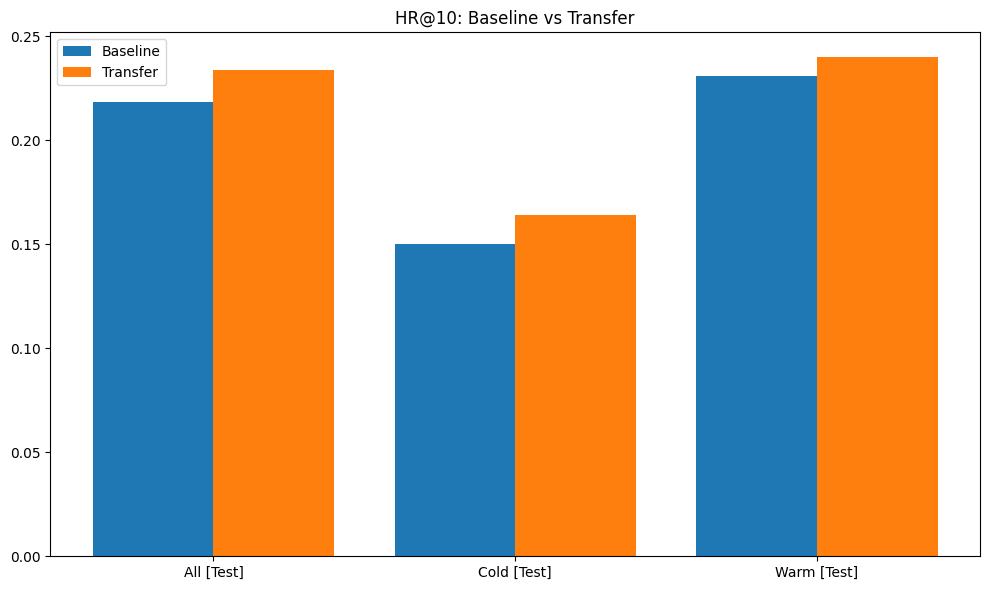

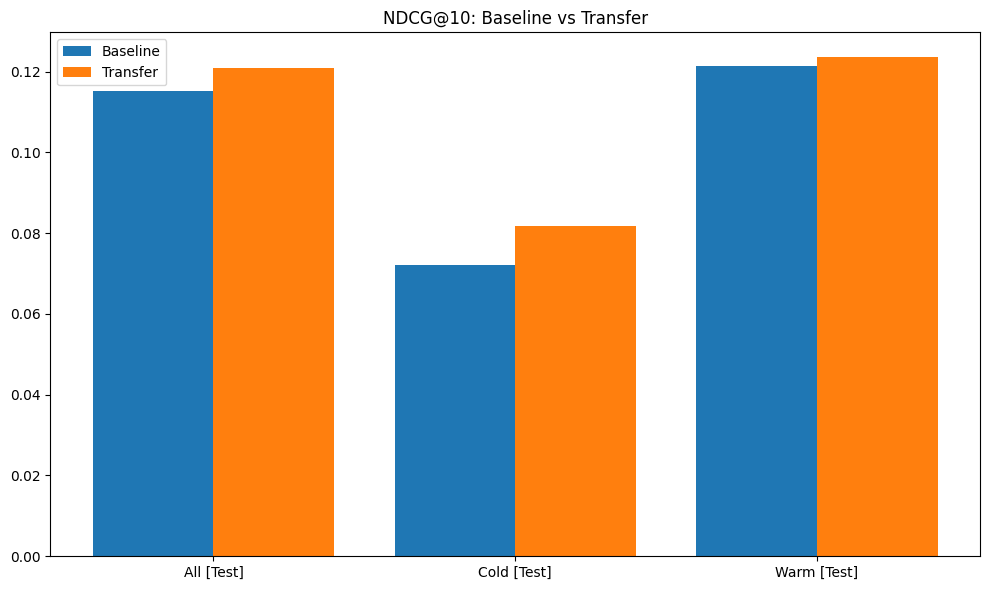

Saved charts: hr10.png, ndcg10.png


In [120]:
# Bar plots
def barplot_metric(df, metric_col_baseline, metric_col_transfer, title, outfile):
    labels = df["Split"].tolist()
    baseline = df[metric_col_baseline].tolist()
    transfer = df[metric_col_transfer].tolist()
    xs = range(len(labels))
    plt.figure(figsize=(10,6))
    plt.bar(xs, baseline, width=0.4, label="Baseline")
    plt.bar([i+0.4 for i in xs], transfer, width=0.4, label="Transfer")
    plt.xticks([i+0.2 for i in xs], labels)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=160)
    plt.show()

barplot_metric(results_df, "Baseline HR@10", "Transfer HR@10", "HR@10: Baseline vs Transfer", "hr10.png")
barplot_metric(results_df, "Baseline NDCG@10", "Transfer NDCG@10", "NDCG@10: Baseline vs Transfer", "ndcg10.png")
print("Saved charts: hr10.png, ndcg10.png")